In [1]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [2]:
fs, p = wavfile.read('sonido-presion/presion_segmento_3.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_3.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_3.wav')
fs, delta_opt = wavfile.read('sonido-presion/delta_opt_segmento_3.wav')
fs, delta2 = wavfile.read('sonido-presion/delta2_segmento_3.wav')

b = b[:-1]

In [7]:
import json
t_silabas_file = open('sonido-presion/t_silabas.json') 

# returns JSON object as a list 
t_silabas = json.load(t_silabas_file) ['segmento_3']

In [4]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4 * 2#reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [5]:
x0 = 0.01
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0

In [6]:
dt_m = 1/fs
N  = len(p)
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} s')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.5542695356738392 s


In [9]:
#dt = 1/884000
dt = dt_m / 20
t = np.arange(0, t_m[-1] + dt_m, dt)

In [10]:
print(len(t_m), len(p), len(delta_opt), len(b))

24472 24472 24472 24472


In [11]:
#inrepolo p

interp_func = interp1d(t_m, b)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))

#interpolo delta
interp_func2 = interp1d(t_m, delta_opt)

delta_interp = interp_func2(np.linspace(0, t_m[-1],len(t) ))

In [12]:
#sumo ruido
sigma_s = np.std(s_m[b<0]/max(s_m))
ruido = np.random.normal(0, sigma_s, len(t))

N_i = len(t)

b_int = b_interpolado

Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0



In [13]:
# Integración: le agrego el ruido a f0 para 

for j in range(N_i):
    params = [4, c, delta_interp[j] *4 + ruido[j]*5, b_int[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    

In [14]:
def y(w,x, beta):
    mu = 1e5
    return w - mu * (x**3/3 - beta * x )

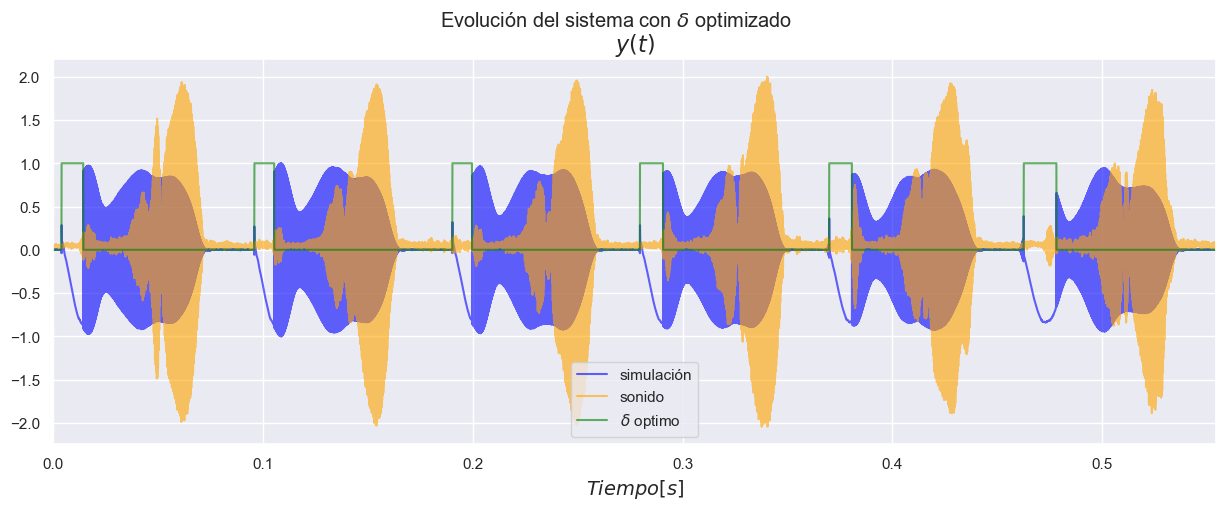

In [18]:
%matplotlib inline
plt.figure( figsize=(15,5))
#ploteo
colors = ['green','red','black','blue']
y_ = y(Xs[:,0][:-1],Xs[:,1][:-1], b_int)
plt.plot(t,y_/max(y_),alpha = .60, color=colors[3], label = r'simulación')
#plt.plot(t,Xs[:,0][:-1] / max(Xs[:,0]),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
#plt.plot(t,b_int,alpha = .60, color=colors[1], label = r'$\beta$')
#plt.plot(t_m,delta2,alpha = .60, color= 'black', label = r'$\delta$ prediccion')
plt.plot(t,delta_interp,alpha = .60, color= 'green', label = r'$\delta$ optimo')
plt.legend(loc=0)
plt.xlim(0., t_m[-1])
#plt.ylim(-2,1.5)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)
plt.suptitle(r"Evolución del sistema con $\delta$ optimizado")
plt.show()